# Load wav2vec 2.0 emotion model

In [1]:
import os

import audeer


src_url = '...'
dst_path = 'model.zip'
model_root = 'model'
cache_root = 'cache'


audeer.mkdir(cache_root)
def cache_path(file):
    return os.path.join(cache_root, file)


# audeer.download_url(src_url, dst_path, verbose=True)
audeer.extract_archive(dst_path, model_root, verbose=True)

['model.onnx', 'model.yaml']

In [2]:
import audonnx


model = audonnx.load(model_root)
model

Input:
  signal:
    shape: [1, -1]
    dtype: tensor(float)
    transform: None
Output:
  hidden_states:
    shape: [1, 1024]
    dtype: tensor(float)
    labels: [hidden_states-0, hidden_states-1, hidden_states-2, (...), hidden_states-1021,
      hidden_states-1022, hidden_states-1023]
  logits:
    shape: [1, 3]
    dtype: tensor(float)
    labels: [arousal, dominance, valence]

# Predict dimensional scores on synthetic files 

In [3]:
import gtts


sentences = [
    'Hello world',
    'This is wonderful',
    'This is stupid',
]

files = []
for sentence in audeer.progress_bar(
    sentences,
    desc='Create files',
):
    path = cache_path(f'{sentence}.mp3')
    files.append(path)
    if not os.path.exists(path):
        tts = gtts.gTTS(sentence)
        tts.save(path)
files

['cache/Hello world.mp3',
 'cache/This is wonderful.mp3',
 'cache/This is stupid.mp3']

In [4]:
import audinterface


logits = audinterface.Feature(
    model.outputs['logits'].labels,
    process_func=model,
    process_func_args={
        'output_names': 'logits',
    },
    sampling_rate=16000,
    resample=True,    
    verbose=True,
)
logits.process_files(files)

,,,arousal,dominance,valence
file,start,end,,,
cache/Hello world.mp3,0 days,0 days 00:00:01.416000,0.500082,0.574856,0.597595
cache/This is wonderful.mp3,0 days,0 days 00:00:01.632000,0.547029,0.647840,0.897838
cache/This is stupid.mp3,0 days,0 days 00:00:01.560000,0.552540,0.659153,-0.002927


# Train categorical model on embeddings

In [5]:
import audb
import audformat


db = audb.load(
    'emodb',
    version='1.1.1',
    format='wav',
    mixdown=True,
    sampling_rate=16000,
    full_path=False,    
)
speaker = db['files']['speaker'].get()
emotion = db['emotion']['emotion'].get()

audformat.utils.concat([emotion, speaker])

Get:   emodb v1.1.1
Cache: /media/jwagner/Data/audb/emodb/1.1.1/fe182b91


,emotion,speaker
file,,
wav/03a01Fa.wav,happiness,3
wav/03a01Nc.wav,neutral,3
wav/03a01Wa.wav,anger,3
wav/03a02Fc.wav,happiness,3
wav/03a02Nc.wav,neutral,3
...,...,...
wav/16b10Lb.wav,boredom,16
wav/16b10Tb.wav,sadness,16
wav/16b10Td.wav,sadness,16


In [6]:
import pandas as pd


hidden_states = audinterface.Feature(
    model.outputs['hidden_states'].labels,
    process_func=model,
    process_func_args={
        'output_names': 'hidden_states',
    },
    sampling_rate=16000,    
    resample=True,    
    num_workers=5,
    verbose=True,
)

path = cache_path('w2v2.pkl')
if not os.path.exists(path):
    features_w2v2 = hidden_states.process_index(
        emotion.index,
        root=db.root,
    )
    features_w2v2.to_pickle(path)    
    
features_w2v2 = pd.read_pickle(path)
features_w2v2

,,,hidden_states-0,hidden_states-1,hidden_states-2,hidden_states-3,hidden_states-4,hidden_states-5,hidden_states-6,hidden_states-7,hidden_states-8,hidden_states-9,...,hidden_states-1014,hidden_states-1015,hidden_states-1016,hidden_states-1017,hidden_states-1018,hidden_states-1019,hidden_states-1020,hidden_states-1021,hidden_states-1022,hidden_states-1023
file,start,end,,,,,,,,,,,,,,,,,,,,,
wav/03a01Fa.wav,0 days,0 days 00:00:01.898250,-0.007891,0.006736,-0.005898,-0.006566,-0.004559,-0.008148,0.168698,0.006812,0.113164,-0.001617,...,0.003587,0.011148,-0.050405,0.008359,0.034025,-0.064220,0.139168,0.007794,0.007637,0.006209
wav/03a01Nc.wav,0 days,0 days 00:00:01.611250,-0.007629,0.006001,-0.007628,-0.006588,-0.005104,-0.008472,0.199000,0.006391,0.071222,-0.001760,...,0.003145,0.011300,-0.018726,0.008156,0.015245,-0.056928,0.083291,0.007600,0.007721,0.005684
wav/03a01Wa.wav,0 days,0 days 00:00:01.877812500,-0.007874,0.006600,-0.008576,-0.007047,-0.004646,-0.008129,0.237001,0.007115,0.188141,-0.001287,...,0.003982,0.011190,-0.036640,0.008163,0.062221,-0.112500,0.302140,0.007813,0.007812,0.007133
wav/03a02Fc.wav,0 days,0 days 00:00:02.006250,-0.007407,0.006326,-0.010519,-0.005899,-0.004216,-0.007912,0.109786,0.006558,0.088926,-0.001507,...,0.003656,0.011320,-0.041450,0.008284,-0.010972,-0.139131,0.366497,0.007560,0.008487,0.004726
wav/03a02Nc.wav,0 days,0 days 00:00:01.439812500,-0.007313,0.006525,-0.010693,-0.004869,-0.004605,-0.008149,0.122609,0.006291,0.032912,-0.001508,...,0.003650,0.010983,-0.058476,0.008078,-0.008553,-0.000632,0.296581,0.007574,0.008161,0.005591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wav/16b10Lb.wav,0 days,0 days 00:00:03.442687500,-0.007212,0.006251,-0.006754,-0.006353,-0.004147,-0.007847,0.023312,0.007121,0.040396,-0.001996,...,0.003988,0.011588,-0.043439,0.008200,-0.027195,-0.063882,-0.051351,0.007314,0.007467,0.005633
wav/16b10Tb.wav,0 days,0 days 00:00:03.500625,-0.007274,0.006054,-0.006579,-0.006229,-0.004043,-0.005949,-0.005269,0.006985,-0.119985,-0.001811,...,0.003704,0.011652,-0.047649,0.008086,-0.013412,0.171493,-0.094538,0.007363,0.006186,0.005715
wav/16b10Td.wav,0 days,0 days 00:00:03.934187500,-0.007491,0.006536,-0.006867,-0.007232,-0.004012,-0.005708,-0.095532,0.006726,-0.191503,-0.002289,...,0.004344,0.011328,-0.064138,0.008109,-0.004146,0.111839,-0.037554,0.007447,0.006693,0.005184


In [7]:
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


logo = LeaveOneGroupOut()
clf = make_pipeline(
    StandardScaler(), 
    SVC(gamma='auto'),
)

def experiment(
    features,
    targets,
    groups,
):        
    truths = []
    preds = []
    
    # leave-one-speaker loop    
    pbar = audeer.progress_bar(
        total=len(groups.unique()),
        desc='Run experiment',
    )
    for train_index, test_index in logo.split(
        features, 
        targets, 
        groups=groups,
    ):
        train_x = features.iloc[train_index]
        train_y = targets[train_index]
        clf.fit(train_x, train_y)
        
        truth_x = features.iloc[test_index]
        truth_y = targets[test_index]
        predict_y = clf.predict(truth_x)
        
        truths.append(truth_y)
        preds.append(predict_y)
        
        pbar.update()
        
    # combine speaker folds
    truth = pd.concat(truths)    
    pred = np.concatenate(preds)
    
    return truth, pred

In [8]:
import audmetric


truth, pred = experiment(
    features_w2v2,
    emotion,
    speaker,
)
audmetric.unweighted_average_recall(truth, pred)

0.9338131704157702

# Benchmark against hand-crafted features

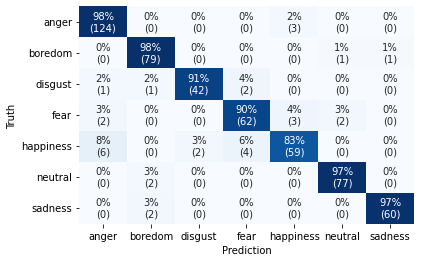

In [9]:
import audplot


audplot.confusion_matrix(
    truth, 
    pred,
    percentage=True,
    show_both=True,
)

In [10]:
import opensmile


smile = opensmile.Smile(
    opensmile.FeatureSet.ComParE_2016,
    opensmile.FeatureLevel.Functionals,
    sampling_rate=16000,    
    resample=True,    
    num_workers=5,
    verbose=True,
)

path = cache_path('smile.pkl')
if not os.path.exists(path):
    features = smile.process_index(
        emotion.index,
        root=db.root,
    )
    features.to_pickle(path)    
    
features_smile = pd.read_pickle(path)
features_smile

,,,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
file,start,end,,,,,,,,,,,,,,,,,,,,,
wav/03a01Fa.wav,0 days,0 days 00:00:01.898250,2.935072,0.203297,0.010989,0.295957,0.521095,1.027880,0.225138,0.506785,0.731923,0.036379,...,4.534245,0.369439,2.608829,2.575876,19.005924,0.681891,117.093933,56.662125,120.517212,53.837585
wav/03a01Nc.wav,0 days,0 days 00:00:01.611250,3.087914,0.155844,0.889610,0.230797,0.747830,1.160158,0.517033,0.412327,0.929361,0.039586,...,5.695178,0.373871,3.123539,3.173356,-18.526028,0.684225,126.975647,63.870255,157.944702,60.625206
wav/03a01Wa.wav,0 days,0 days 00:00:01.877812500,3.673083,0.677778,0.011111,0.379012,0.901301,1.801537,0.522289,0.900236,1.422525,0.027108,...,8.072537,0.486622,3.802572,3.807790,-19.999348,0.385978,177.820740,89.425529,153.756653,92.122215
wav/03a02Fc.wav,0 days,0 days 00:00:02.006250,3.149658,0.549223,0.720207,0.252871,0.691515,1.456156,0.438644,0.764641,1.203285,0.044348,...,8.049533,0.537332,3.237765,3.310604,-17.577114,0.442254,161.931686,82.129478,134.208984,73.309341
wav/03a02Nc.wav,0 days,0 days 00:00:01.439812500,2.437313,0.632353,0.691176,0.386229,0.809192,1.433426,0.422963,0.624234,1.047197,0.047513,...,6.743878,0.511177,2.217380,2.281038,-16.731733,0.492748,106.720039,57.315079,97.520103,41.168545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wav/16b10Lb.wav,0 days,0 days 00:00:03.442687500,3.308008,0.100890,0.014837,0.450570,0.805156,1.323949,0.354586,0.518794,0.873379,0.059215,...,8.917046,0.681655,2.385576,2.390011,-19.996981,0.537082,118.114395,65.305817,102.050064,44.002724
wav/16b10Tb.wav,0 days,0 days 00:00:03.500625,2.817487,0.104956,0.472303,0.298808,0.898184,1.372837,0.599376,0.474654,1.074030,0.111207,...,8.454210,0.531393,3.011052,3.035630,-19.587982,0.486605,133.106750,83.190590,112.855782,72.329666
wav/16b10Td.wav,0 days,0 days 00:00:03.934187500,1.854920,0.119171,0.000000,0.208670,0.607462,1.031825,0.398792,0.424362,0.823154,0.102642,...,6.234570,0.470659,2.219766,2.233577,-19.786058,0.620368,110.055237,51.608723,83.898209,39.287560


In [11]:
truth, pred = experiment(
    features_smile,
    emotion,
    speaker,
)
audmetric.unweighted_average_recall(truth, pred)

0.7707603332902749

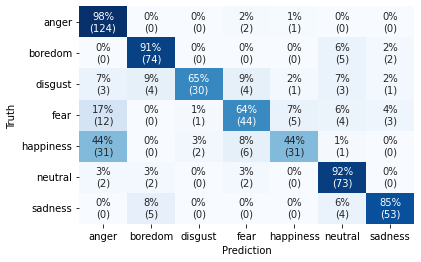

In [12]:
audplot.confusion_matrix(
    truth, 
    pred,
    percentage=True,
    show_both=True,
)